# Zero Quadratic Model

In [4]:
import tenpy.tools.process as prc
import numpy as np
import matplotlib.pyplot as plt
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square


class ZeroQuadraticModel(CouplingMPOModel):

    def __init__(self, params):
        CouplingMPOModel.__init__(self, params)

    @staticmethod
    def stats(params):
        return params.get('mod', 'Bos')

    def init_sites(self, params):
        conserve = params.get('conserve', 'N')
        if "Bos" in self.stats(params):
            Nmax = params.get('Nmax', 1)
            site = BosonSite(Nmax=Nmax, conserve=conserve)  # conserve=conserve
        else:
            site = FermionSite(conserve=conserve)
        return site

    def init_lattice(self, params):
        if "Bos" in self.stats(params):
            L_default = (4, 4)
        else:
            L_default = (3, 6)
        L = params.get('L', L_default)
        #L = (params.get('Lx', 4), params.get('Ly',4))
        order = params.get('order', 'Cstyle')
        bc_MPS = params.get('bc_MPS', 'infinite')
        bc_x = params.get('bc_x', 'periodic')
        bc_y = params.get('bc_y', 'periodic')
        bc = [bc_x, bc_y]
        site = self.init_sites(params)
        lat = Square(L[0], L[1], site, order=order, bc_MPS=bc_MPS, bc=bc)
        return lat

    def init_terms(self, params):
        if "Bos" in self.stats(params):
            creation, annihilation = 'Bd', 'B'
            nphi_default = (1, 4)
            L_default = (4, 4)
            V_default = 0
        else:
            creation, annihilation = 'Cd', 'C'
            nphi_default = (1, 3)
            L_default = (6, 6)
            V_default = 10
        t = params.get('t', 1)
        t3 = params.get('t3', 0) #Change this for t_3
        nphi = params.get('nphi', nphi_default)
        nphi_2pi = 2 * np.pi * nphi[0] / nphi[1]
        phi_2pi = 2 * np.pi * params.get('phi', 0.0)
        L = params.get('L', L_default)
        _Lx, _Ly = L[0], L[1]
        V = params.get('V', V_default)
        mu = params.get('mu', 0)

        # --- x-hopping 
        dx = np.array([1, 0])
        # print(lat.coupling_shape(dx))
        tx_phi = -t*np.ones((_Lx, _Ly), dtype=complex)
        tx3_phi = -t3*np.ones((_Lx, _Ly), dtype=complex)
        # print("tx_phi = ", tx_phi)
        self.add_coupling(-t, 0, creation, 0, annihilation, dx)
        self.add_coupling(np.conj(-t), 0, creation, 0, annihilation, -dx)  # H.c.
        self.add_coupling(-t3, 0, creation, 0, annihilation, 2*dx)
        self.add_coupling(np.conj(-t3), 0, creation, 0, annihilation, -2*dx)

        # --- y-hopping (Landau-x gauge)
        dy = np.array([0, 1])
        # print(lat.coupling_shape(dy))
        ty_phi = -t*np.ones((_Lx, _Ly), dtype=complex)
        ty_phi = self.coupling_strength_add_ext_flux(ty_phi, dy, [0, phi_2pi])
        ty3_phi = -t3*np.ones((_Lx, _Ly), dtype=complex)
        ty3_phi = self.coupling_strength_add_ext_flux(ty3_phi, 2*dy, [0, phi_2pi])
        for ix in range(_Lx):
            ty_phi[ix, :] *= np.exp(1j * ix * nphi_2pi)
            ty3_phi[ix, :] *= np.exp(1j*ix*nphi_2pi*2)
        self.add_coupling(ty_phi, 0, creation, 0, annihilation, dy)
        self.add_coupling(np.conj(ty_phi), 0, creation, 0, annihilation, -dy)  # H.c.
        self.add_coupling(ty3_phi, 0, creation, 0, annihilation, 2*dy)
        self.add_coupling(np.conj(ty3_phi), 0, creation, 0, annihilation, -2*dy)
        self.add_coupling(V, 0, 'N', 0, 'N', dx)
        self.add_coupling(V, 0, 'N', 0, 'N', dy)
        
        # --- chemical potential
        #self.add_onsite(-mu, 0, 'N') #(No onsite potential)

# Metal->FCI Transition (1/4)



In [3]:
import numpy as np
import random

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import BosonSite, FermionSite
from tenpy.models.lattice import Square

import logging
logging.basicConfig(level=logging.INFO)

#prc.mkl_set_nthreads(8) #should run on 8 threads (use for work station )

data2 = dict(V_range=np.linspace(0, 0.6, 30), corr_len = [], exp_val=[], ent_entropy=[], ent_spectrum=[])

#print('corr_length is {}'.format(psi.correlation_length()))
#print('ent entropy is {}'.format(psi.entanglement_entropy()[0]))
#print('exp value is {}'.format(hamiltonian.expectation_value(psi)))


model_params = dict(Lx=4, Ly=6, L = (4, 6), filling=(1, 12), nphi=(1, 4), mod = 'HosFerm',
                    Jx=1, Jy=1, mu=0, V=0, mx=4, my=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x', t3 = 0)


dmrg_params = {
    'mixer': True,  # setting this to True helps to escape local minima
    'mixer_params': {
        'amplitude': 1.e-5,
        'decay': 1.2,
        'disable_after': 30
    },
    'trunc_params': {
        'chi_max': 50, #bond_dim (CHANGED)
        'svd_min': 1.e-10,
    },
    'lanczos_params': {
        'cutoff': 1.e-13
    },
#    'chi_list':{0: 9, 10: 49, 20: 100, 40: 200}, #(CHANGED)
    'max_E_err': 1.e-6,
    'max_S_err': 1.e-6,
    'max_sweeps': 150,
    'verbose': 1,
    'combine': True
}

Ln = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(Ln, dtype=int)
prod_state[random.sample(range(Ln), int(fill*Ln))] = 1

eng = None
for V_i in data2['V_range']:
    model_params['V'] = V_i
    M = ZeroQuadraticModel(model_params)
    #if eng is None:  # first time in the loop
    psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    #else:
    #    dmrg_params['mixer'] = False
    #    eng.init_env(model=M)  # re-initialize
    E, psi = eng.run()
    hamiltonian = M.calc_H_MPO()
    data2['corr_len'].append(psi.correlation_length())
    data2['exp_val'].append(hamiltonian.expectation_value(psi))
    data2['ent_entropy'].append(psi.entanglement_entropy()[0])
    data2['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])

Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'L'=(4, 6) for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 't3'=0 for config ZeroQuadraticModel
Reading 'nphi'=(1, 4) for config ZeroQuadraticModel
Reading 'V'=0.0 for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<2 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Updating environment
.


/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:2771: RuntimeWarning: divide by zero encountered in reciprocal
  S = S**form_diff
/Users/mathiraja/TeNPy/tenpy/algorithms/dmrg.py:1997: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


Reading 'max_sweeps'=150 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....
sweep 10, age = 792
Energy = -0.2091410245724627, S = nan, norm_err = 2.6e-02
Current memory usage 291376.0 MB, time elapsed: 223.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3152e-06, max_E_trunc = 7.9152e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 1512
Energy = -0.2312700792484463, S = nan, norm_err = 7.9e-02
Current memory usage 299680.0 MB, time elapsed: 475.6 s
Delta E = -2.2129e-03, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0839e-06, max_E_trunc = 1.1941e-06
MPS bond dimensions: 

KeyboardInterrupt: 

In [ ]:
#bd = 50
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
plt.title('corr_len')
ax.plot(data2['V_range'], data2['corr_len'], marker='o')
plt.savefig('corr_len_0-06')

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
plt.title('ent_entropy')
ax.plot(data2['V_range'], data2['ent_entropy'], marker='o')
plt.savefig('ent_entropy_0-06')

plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
plt.title('exp_val')
ax.plot(data2['V_range'], data2['exp_val'], marker='o')
plt.savefig('exp_val_0-06')

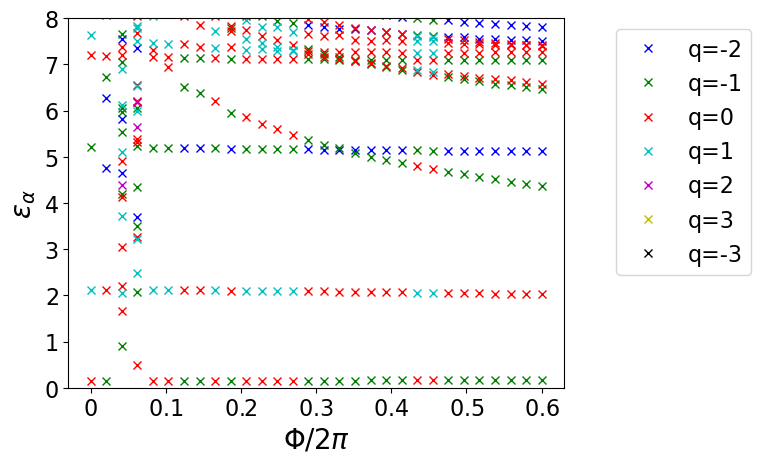

<Figure size 640x480 with 0 Axes>

In [6]:
phi_ext = np.linspace(0, 3.0, 10)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_by_charge = {}
for V_range, spectrum in zip(data2['V_range'], data2['ent_spectrum']):
    for q, s in spectrum:
        if q > -4:
            q = q[0]
            label = ""
            if q not in color_by_charge:
                label = "q={q:d}".format(q=q)
                color_by_charge[q] = colors[len(color_by_charge) % len(colors)]
            color = color_by_charge[q]
            ax.plot(V_range*np.ones(s.shape), s,
                    linestyle='', marker='x', color=color, label=label)
ax.set_xlabel(r"$\Phi / 2 \pi$", fontsize=20)
ax.set_ylabel(r"$ \epsilon_\alpha $", fontsize=20)
ax.set_ylim(0., 8.)
ax.legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.4, 1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
#ax.set_xlim([0, 2])
plt.show()
plt.savefig('')

In [18]:
model_params = dict(Lx=3, Ly=6, filling=(1, 9), nphi=(1, 3), mod = 'HosFerm',
                    Jx=1, Jy=1, mu=0, v=10, mx=3, my=1,
                    bc_MPS='infinite', bc_x='periodic', bc_y='periodic',
                    conserve='N', order='default', gauge='landau_x', t = 0, t3 = 0)


M = ZeroQuadraticModel(model_params)
hamiltonian = M.calc_H_MPO()
L = model_params['Lx'] * model_params['Ly']
fill = model_params['filling'][0] / model_params['filling'][1]
prod_state = np.zeros(L, dtype=int)
prod_state[random.sample(range(L), int(fill*L))] = 1
psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
print('corr_length is {}'.format(psi.correlation_length()))
print('ent entropy is {}'.format(psi.entanglement_entropy()[0]))
print('exp value is {}'.format(hamiltonian.expectation_value(psi)))


Reading 'mod'='HosFerm' for config ZeroQuadraticModel
Reading 'order'='default' for config ZeroQuadraticModel
Reading 'bc_MPS'='infinite' for config ZeroQuadraticModel
Reading 'bc_x'='periodic' for config ZeroQuadraticModel
Reading 'bc_y'='periodic' for config ZeroQuadraticModel
Reading 'conserve'='N' for config ZeroQuadraticModel
Reading 't'=0 for config ZeroQuadraticModel
Reading 't3'=0 for config ZeroQuadraticModel
Reading 'nphi'=(1, 3) for config ZeroQuadraticModel
Reading 'mu'=0 for config ZeroQuadraticModel
corr_length is 0.0
ent entropy is -0.0
<class '__main__.ZeroQuadraticModel'>
exp value is 0.5555555555555556


/Users/mathiraja/TeNPy/tenpy/tools/params.py:225: UserWarning: unused options for config ZeroQuadraticModel:
['Jx', 'Jy', 'Lx', 'Ly', 'filling', 'gauge', 'mx', 'my', 'v']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/Users/mathiraja/TeNPy/tenpy/networks/mps.py:3697: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)
